In [1]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import cv2
import os
import PIL
import pathlib
import splitfolders
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,MaxPooling2D,Conv2D,Dropout,Activation,BatchNormalization
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report,confusion_matrix
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import warnings 
warnings.filterwarnings('ignore')

In [3]:
data_path="/content/drive/MyDrive/machine learning projects/training set/Rice_Image_Dataset"
data_path=pathlib.Path(data_path)
data_path

PosixPath('/content/drive/MyDrive/machine learning projects/training set/Rice_Image_Dataset')

In [4]:
from splitfolders import split
splitfolders.ratio(data_path,output='img',seed=123,ratio=(0.7,0.15,0.15),group_prefix=None)

Copying files: 75000 files [18:57, 65.92 files/s] 


In [5]:
arborio = [fn for fn in os.listdir(f'{data_path}/Arborio') if fn.endswith('.jpg')]
bastmati = [fn for fn in os.listdir(f'{data_path}/Basmati') if fn.endswith('.jpg')]
ipsala = [fn for fn in os.listdir(f'{data_path}/Ipsala') if fn.endswith('.jpg')]
jasmine = [fn for fn in os.listdir(f'{data_path}/Jasmine') if fn.endswith('.jpg')]
karacadag = [fn for fn in os.listdir(f'{data_path}/Karacadag') if fn.endswith('.jpg')]
rice = [arborio, bastmati, ipsala, jasmine, karacadag]
rice_classes = []
for i in os.listdir('img/train'):
    rice_classes+=[i]
rice_classes.sort()

Total images: 75000
Total number of classes: 5
Total Arborio images: 15000
Total Basmati images: 15000
Total Ipsala images: 15000
Total Jasmine images: 15000
Total Karacadag images: 15000


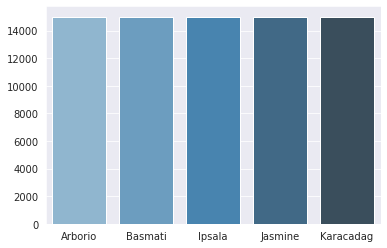

In [6]:
image_count = len(list(data_path.glob('*/*.jpg')))
print(f'Total images: {image_count}')
print(f'Total number of classes: {len(rice_classes)}')
count = 0
rice_count = []
for x in rice_classes:
  print(f'Total {x} images: {len(rice[count])}')
  rice_count.append(len(rice[count]))
  count += 1

sns.set_style('darkgrid')
sns.barplot(x=rice_classes, y=rice_count, palette="Blues_d")
plt.show()

In [7]:
def load_random_img(dir, label):
  plt.figure(figsize=(10,10))
  i=0
  for label in rice_classes:
    i+=1
    plt.subplot(1, 5, i)
    file = random.choice(os.listdir(f'{dir}/{label}'))
    image_path = os.path.join(f'{dir}/{label}', file)
    img=cv2.imread(image_path)
    plt.title(label)
    plt.imshow(img)
    plt.grid(None)
    plt.axis('off')

In [8]:
batch_size = 128
img_height, img_width = 175, 175
input_shape = (img_height, img_width, 3)

In [9]:
train_ds=ImageDataGenerator(rescale=1./255).flow_from_directory(
    'img/train',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    subset = "training",
    class_mode='categorical')

val_ds = ImageDataGenerator(rescale=1./255).flow_from_directory(
    'img/val',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

test_ds = ImageDataGenerator(rescale=1./255).flow_from_directory(
    'img/test',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

Found 52500 images belonging to 5 classes.
Found 11250 images belonging to 5 classes.
Found 11250 images belonging to 5 classes.


In [10]:
def plot_train_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [11]:
model=Sequential()

model.add(Conv2D(32,(3,3), activation='relu',input_shape=(175,175,3)))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3), activation='relu',padding='same'))
model.add(BatchNormalization(axis=3))
model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
model.add(Dropout(0.3))

model.add(Conv2D(64,(3,3), activation='relu',input_shape=(175,175,3)))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3), activation='relu',padding='same'))
model.add(BatchNormalization(axis=3))
model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
model.add(Dropout(0.3))

model.add(Conv2D(128,(3,3), activation='relu',input_shape=(175,175,3)))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3), activation='relu',padding='same'))
model.add(BatchNormalization(axis=3))
model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5,activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 173, 173, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 173, 173, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 173, 173, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 173, 173, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 87, 87, 32)       0         
 )                                                               
                                                        

In [15]:
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

checkpointer = ModelCheckpoint(filepath='saved_models/model_vanilla.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.001)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [16]:
model.fit(
    train_ds,epochs=40,validation_data=val_ds,callbacks=callbacks
)

Epoch 1/40
411/411 [==============================] - ETA: 0s - loss: 0.1166 - accuracy: 0.9592
Epoch 1: val_accuracy improved from -inf to 0.20000, saving model to saved_models/model_vanilla.hdf5
411/411 [==============================] - 212s 474ms/step - loss: 0.1166 - accuracy: 0.9592 - val_loss: 66.1674 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 2/40
411/411 [==============================] - ETA: 0s - loss: 0.0403 - accuracy: 0.9865
Epoch 2: val_accuracy improved from 0.20000 to 0.81947, saving model to saved_models/model_vanilla.hdf5
411/411 [==============================] - 185s 451ms/step - loss: 0.0403 - accuracy: 0.9865 - val_loss: 0.4531 - val_accuracy: 0.8195 - lr: 0.0010
Epoch 3/40
411/411 [==============================] - ETA: 0s - loss: 0.0313 - accuracy: 0.9902
Epoch 3: val_accuracy improved from 0.81947 to 0.96720, saving model to saved_models/model_vanilla.hdf5
411/411 [==============================] - 184s 448ms/step - loss: 0.0313 - accuracy: 0.9902 - val_loss: 0

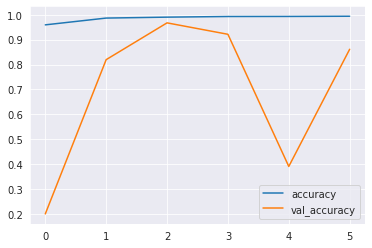

In [21]:
losses=pd.DataFrame(model.history.history)
losses[['accuracy','val_accuracy']].plot()

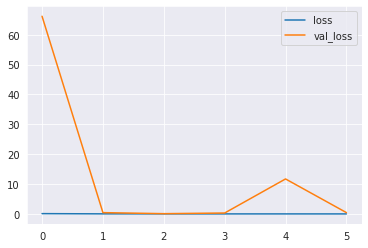

In [24]:
losses[['loss','val_loss']].plot()

In [23]:
score1 = model.evaluate(test_ds, verbose=1)

88/88 [==============================] - 20s 228ms/step - loss: 0.1014 - accuracy: 0.9651


In [26]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict(test_ds)

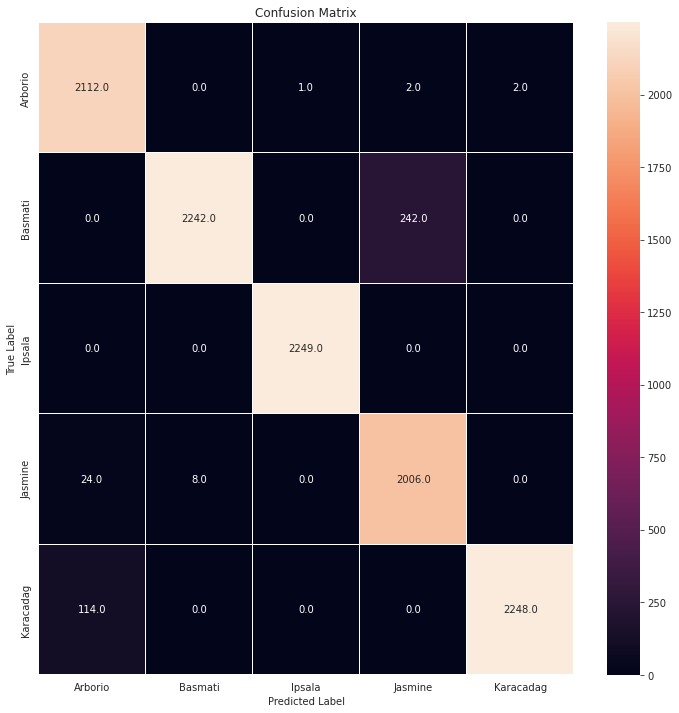

In [27]:
y_pred = np.argmax(Y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(rice_classes)
plt.title("Confusion Matrix")
plt.show()

In [28]:
report1 = classification_report(test_ds.classes, y_pred, target_names=rice_classes, output_dict=True)
df1 = pd.DataFrame(report1).transpose()
df1

,precision,recall,f1-score,support
Arborio,0.997638,0.938667,0.967254,2250.000000
Basmati,0.902576,0.996444,0.947191,2250.000000
Ipsala,1.000000,0.999556,0.999778,2250.000000
Jasmine,0.984298,0.891556,0.935634,2250.000000
Karacadag,0.951736,0.999111,0.974848,2250.000000
accuracy,0.965067,0.965067,0.965067,0.965067
macro avg,0.967250,0.965067,0.964941,11250.000000
weighted avg,0.967250,0.965067,0.964941,11250.000000
